In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import tensorflow as tf

sys.path.append('../')

from dataset.models.tf import TFModel, VGG7, VGG16
from dataset.models.tf.layers import conv_block, global_average_pooling
from tqdm import tqdm
from dataset import B, V, C, Pipeline
from dataset.opensets import MNIST
from detection_mnist import DetectionMnist
from faster_rcnn import *
%matplotlib inline

In [2]:
IMAGE_SHAPE = (128, 128)
MNIST_PER_IMAGE = (2, 6)
BATCH_SIZE = 16
RESIZE_TO = (28, 28)
ANCHORS_BATCH_SIZE = 16

In [3]:
sess = tf.Session()

with sess.graph.as_default():

    inputs = tf.placeholder(tf.float32, (None,) + IMAGE_SHAPE + (1,))
    batch_mode = tf.placeholder(tf.bool)
    
    b_norm = {'momentum': 0.1, 'training': batch_mode}
    
    feature_maps = VGG7.body(inputs, batch_norm=b_norm)
    rpn_reg, rpn_cls, n_anchors = rpn(feature_maps)

    anchors = tf.placeholder(tf.float32, shape=[n_anchors, 4], name='anchors')
    anchors_batch = tf.placeholder(tf.float32, shape=[None, n_anchors], name='anchors_batch')
    anchors_cls = tf.placeholder(tf.float32, shape = [None, n_anchors], name='anchors_cls')
    anchors_reg = tf.placeholder(tf.float32, shape = [None, n_anchors, 4], name='anchors_reg')

    bbox_labels = tf.placeholder(tf.int32, shape=[None, n_anchors], name='labels')

    # parametrize reg
    anchors_reg_param = parametrize(anchors_reg, anchors)

    # unparametrize reg and clsf
    rpn_reg_unparam = unparametrize(rpn_reg, anchors)
    rpn_cls_unparam = tf.sigmoid(rpn_cls)
    
    # perform NMS on RPN inputs
    rcn_input_indices = non_max_suppression(rpn_reg_unparam, rpn_cls_unparam, BATCH_SIZE, n_anchors, 
                                            iou_threshold=0.4, score_threshold=0.7, nonempty=True)
    
    rcn_input_rois, rcn_input_labels = get_rois_and_labels(rpn_reg_unparam, bbox_labels, rcn_input_indices, BATCH_SIZE)

    roi_factor = np.array(feature_maps.get_shape().as_list()[1:3]) / np.array(inputs.get_shape().as_list()[1:3])
    
    #rcn_input_rois = stop_gradient_tuple(rcn_input_rois)
    #rcn_input_labels = stop_gradient_tuple(rcn_input_labels)
    
    roi_cropped = roi_pooling_layer(feature_maps, rcn_input_rois, factor=roi_factor, shape=(7, 7))      
    
    indices, roi_cropped, rcn_input_labels = stack_tuple(roi_cropped, rcn_input_labels)
    
    output_cls = conv_block(roi_cropped, 'f', units=10, name='output_conv')
    
    loss1 = rpn_loss(rpn_reg, rpn_cls, anchors_reg_param, anchors_cls, anchors_batch)
    loss2 = rcn_loss(output_cls, rcn_input_labels)
    
    output = unstack_tuple(output_cls, indices)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):    

        opt1 = tf.train.AdamOptimizer()
        train_step1 = opt1.minimize(loss1)

        opt2 = tf.train.AdamOptimizer()
        train_step2 = opt2.minimize(loss2)

In [4]:
tf.summary.FileWriter('./train', sess.graph)

In [5]:
sess.run(tf.global_variables_initializer())

In [6]:
mnist = MNIST(batch_class=DetectionMnist)

ExtractingExtractingExtractingExtracting    C:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gz





In [7]:
ppl_cfg = dict(rpn=dict(output_map_shape=feature_maps.get_shape().as_list()[1:3]))
train_pp = (Pipeline(config=ppl_cfg)
            .init_variable('loss_history', init_on_each_run=list)
            .generate_images(image_shape=IMAGE_SHAPE, n_digits=MNIST_PER_IMAGE, resize_to=RESIZE_TO)
            .create_anchors(IMAGE_SHAPE)
            .create_rpn_inputs()
            .batch_anchors(batch_size = ANCHORS_BATCH_SIZE)
            .transform_clsf()
            )
train_pp = train_pp << mnist.train

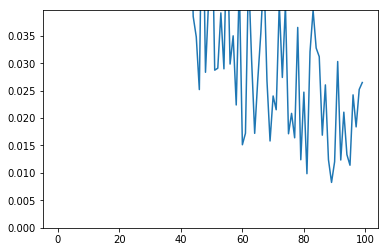

In [8]:
from IPython.display import clear_output
train_loss1 = []
train_loss2 = []
for i in range(100):
    batch = train_pp.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
    labels = batch.data.anchor_labels
    #labels[batch.data.clsf < 0.2] = 10
    
    def B(name):
        return getattr(batch.data, name)

    feed_dict = {inputs: B('images'),
                 batch_mode: True,
                 anchors_cls: B('clsf'),
                 anchors_reg: B('reg'),
                 bbox_labels: labels,
                 anchors_batch: B('anchor_batch'),
                 anchors: B('anchors')}
    
    res = sess.run([train_step1, loss1], feed_dict=feed_dict)    
    train_loss1.append(res[1])    
    clear_output(True)
    current_max = np.max(train_loss1[-20:])
    plt.plot(train_loss1)
    plt.ylim([0,current_max])
    plt.show()

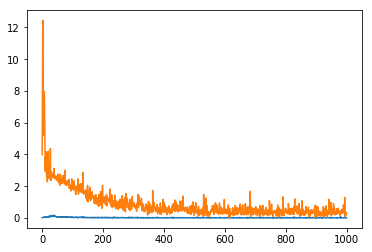

In [9]:
train_loss1 = []
train_loss2 = []

for i in range(1000):
    batch = train_pp.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
    labels = batch.data.anchor_labels
    #labels[batch.data.clsf < 0.2] = 10
    
    def B(name):
        return getattr(batch.data, name)

    feed_dict = {inputs: B('images'),
                 batch_mode: True,
                 anchors_cls: B('clsf'),
                 anchors_reg: B('reg'),
                 bbox_labels: labels,
                 anchors_batch: B('anchor_batch'),
                 anchors: B('anchors')}    
    
    res = sess.run([train_step1], feed_dict=feed_dict)
    res = sess.run([train_step2, loss1, loss2], feed_dict=feed_dict)
    
    
    train_loss1.append(res[1])
    train_loss2.append(res[2])    
    
    clear_output(True)
    plt.plot(train_loss1)
    plt.plot(train_loss2)
    plt.plot
    plt.show()

In [10]:
test_pp = (Pipeline(config=train_pp.config)
            .init_variable('loss_history', init_on_each_run=list)
            .generate_images(image_shape=IMAGE_SHAPE, n_digits=MNIST_PER_IMAGE, resize_to=RESIZE_TO)
            .create_anchors(IMAGE_SHAPE)
            .create_rpn_inputs()
            .batch_anchors(batch_size=ANCHORS_BATCH_SIZE)
            .transform_clsf()
          )
test_pp = test_pp << mnist.test

In [14]:
batch = test_pp.next_batch(50, n_epochs=None, shuffle=True)

labels = batch.data.anchor_labels

def B(name):
    return getattr(batch.data, name)

feed_dict = {inputs: B('images'),
             batch_mode: False,
             anchors_cls: B('clsf'),
             anchors_reg: B('reg'),
             bbox_labels: labels,
             anchors_batch: B('anchor_batch'),
             anchors: B('anchors')} 

roi, ind, pred = sess.run([rpn_reg_unparam, rcn_input_indices, output], feed_dict=feed_dict)

In [15]:
pred = [np.argmax(pred[i], axis=1) for i in range(len(pred))]

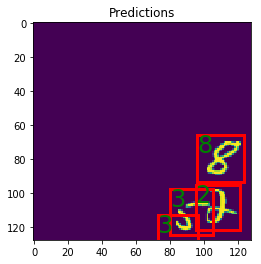

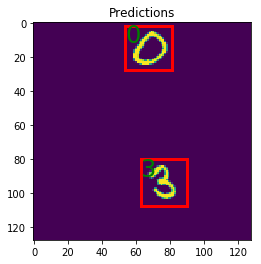

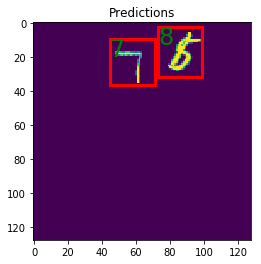

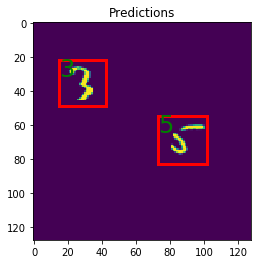

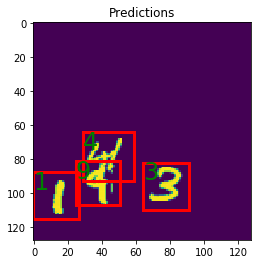

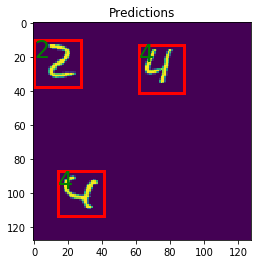

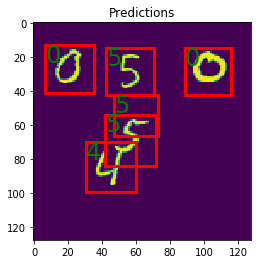

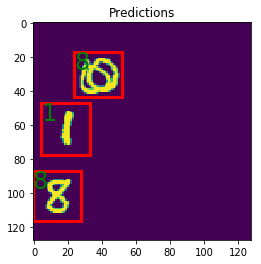

In [16]:
for i in range(8):
    im = batch.data.images[i, :, :, 0]
    bboxes = roi[i][np.squeeze(ind[i])]
    
    fig, ax = plt.subplots(1)

    ax.imshow(im)

    for j, bbox in enumerate(bboxes):      
        rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3], bbox[2], linewidth=3, edgecolor='r', facecolor='none')
        plt.text(bbox[1], bbox[0]+10, pred[i][j], color='g', size=24)
        ax.add_patch(rect)
        
    plt.title('Predictions')
    plt.show()